In [115]:
import numpy as np
import matplotlib.pyplot as plt
import ticktack
from jax import jit
import jax.numpy as jnp
from ticktack import fitting, resample
from scipy.interpolate import interp1d
plt.rcParams['figure.figsize'] = (8.0, 6.0)
#from helper import run_resample, load_IntCal20
import pandas as pd
from scipy.signal import argrelextrema
from scipy.interpolate import interp1d
import statistics

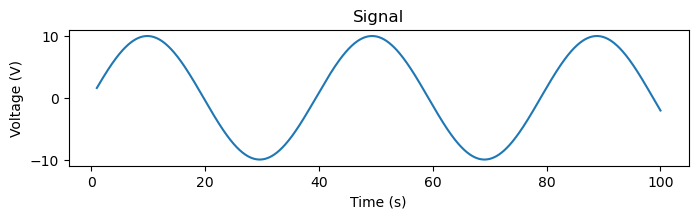

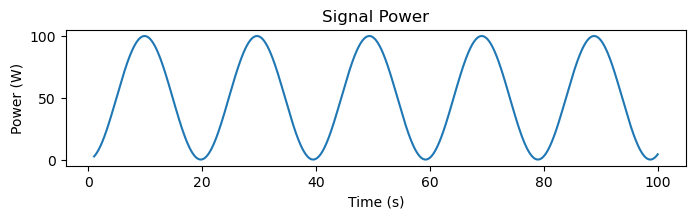

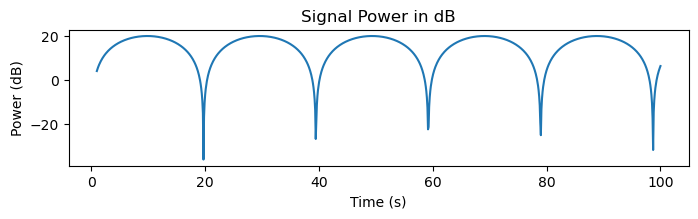

In [116]:
##THIS CODE IS FROM HERE: https://stackoverflow.com/questions/14058340/adding-noise-to-a-signal-in-python

t= np.linspace(1, 100, 1000)
x_volts = 10*np.sin(t/(2*np.pi))
plt.subplot(3,1,1)
plt.plot(t, x_volts)
plt.title('Signal')
plt.ylabel('Voltage (V)')
plt.xlabel('Time (s)')
plt.show()

x_watts = x_volts ** 2
plt.subplot(3,1,2)
plt.plot(t, x_watts)
plt.title('Signal Power')
plt.ylabel('Power (W)')
plt.xlabel('Time (s)')
plt.show()

x_db = 10 * np.log10(x_watts)
plt.subplot(3,1,3)
plt.plot(t, x_db)
plt.title('Signal Power in dB')
plt.ylabel('Power (dB)')
plt.xlabel('Time (s)')
plt.show()

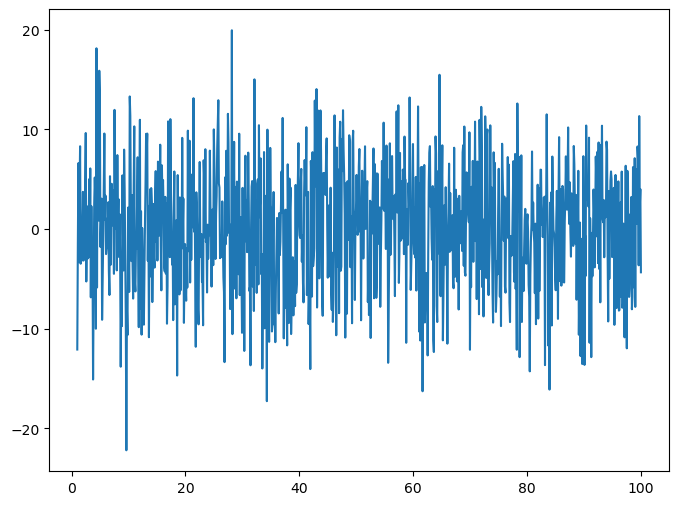

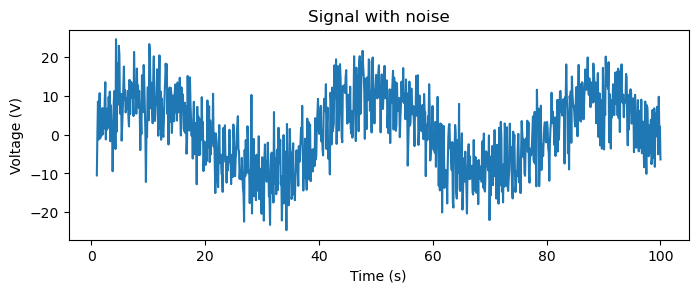

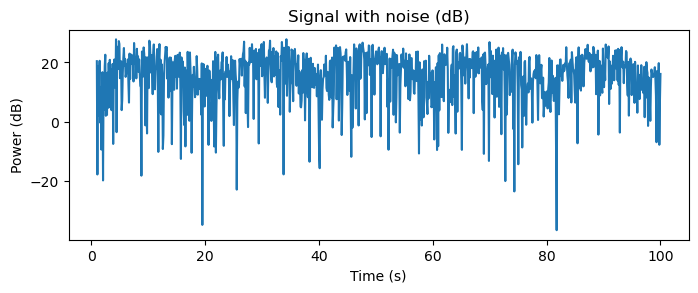

In [125]:
target_snr_db = 1 #this is ALLEDGEDLY the SNR
# Calculate signal power and convert to dB 
sig_avg_watts = np.mean(x_watts)
sig_avg_db = 10 * np.log10(sig_avg_watts)
# Calculate noise according to [2] then convert to watts
noise_avg_db = sig_avg_db - target_snr_db
noise_avg_watts = 10 ** (noise_avg_db / 10)
# Generate an sample of white noise
mean_noise = 0
noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(x_watts))
# Noise up the original signal
y_volts = x_volts + noise_volts

# Plot signal with noise
plt.subplot(2,1,1)
plt.plot(t, y_volts)
plt.title('Signal with noise')
plt.ylabel('Voltage (V)')
plt.xlabel('Time (s)')
plt.show()
# Plot in dB
y_watts = y_volts ** 2
y_db = 10 * np.log10(y_watts)
plt.subplot(2,1,2)
plt.plot(t, 10* np.log10(y_volts**2))
plt.title('Signal with noise (dB)')
plt.ylabel('Power (dB)')
plt.xlabel('Time (s)')
plt.show()

In [118]:
#target_noise_db = 10

# Convert to linear Watt units
#target_noise_watts = 10 ** (target_noise_db / 10)

# Generate noise samples
#mean_noise = 0
#noise_volts = np.random.normal(mean_noise, np.sqrt(target_noise_watts), len(x_watts))

# Noise up the original signal (again) and plot
#y_volts = x_volts + noise_volts

# Plot signal with noise
#plt.subplot(2,1,1)
#plt.plot(t, y_volts)
#plt.title('Signal with noise')
#plt.ylabel('Voltage (V)')
#plt.xlabel('Time (s)')
#plt.show()
# Plot in dB
#y_watts = y_volts ** 2
#y_db = 10 * np.log10(y_watts)
#plt.subplot(2,1,2)
#plt.plot(t, 10* np.log10(y_volts**2))
#plt.title('Signal with noise')
#plt.ylabel('Power (dB)')
#plt.xlabel('Time (s)')
#plt.show()

<ErrorbarContainer object of 3 artists>

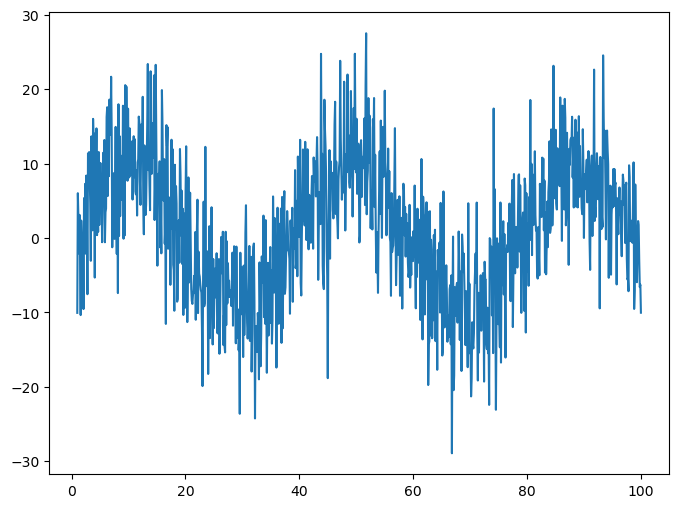

In [119]:
new_signal=y_volts
errors=np.ones(1000)
load_data={'year':t,
          'd14c':new_signal,
          'sig_d14c':errors}
data=pd.DataFrame(load_data)
plt.errorbar(data.year, data.d14c)#, yerr=data.sig_d14c, linestyle='None')

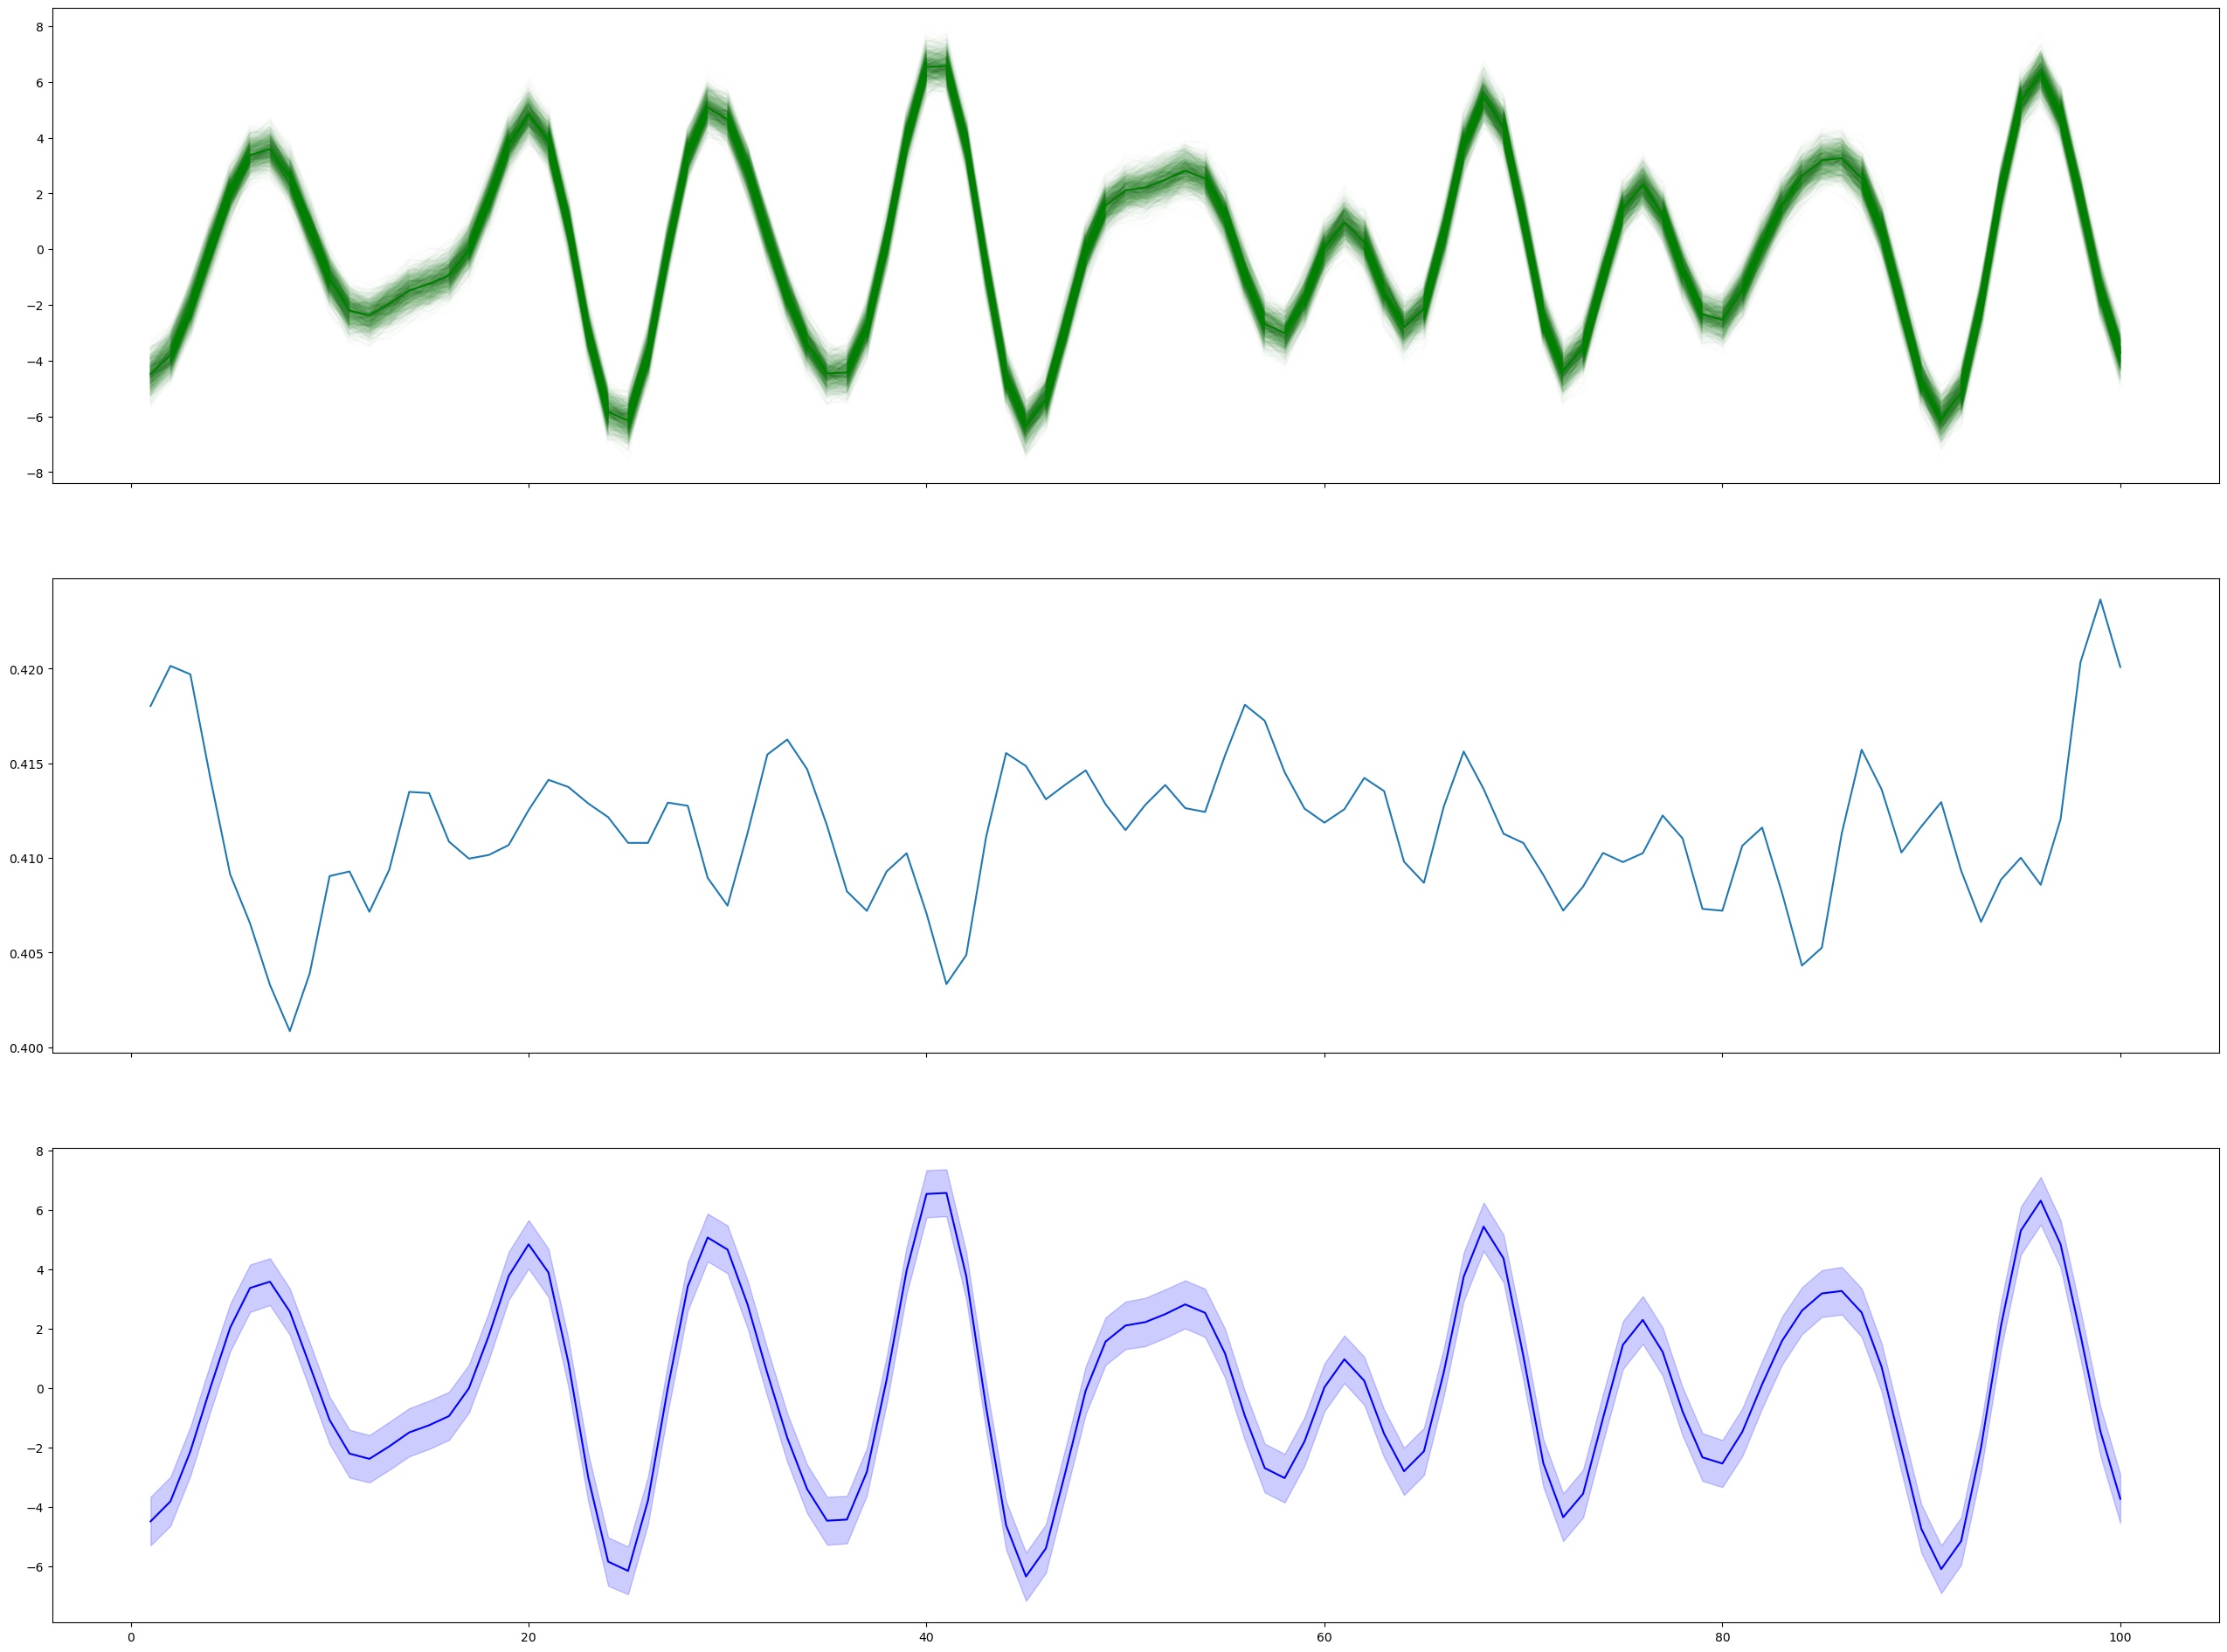

In [120]:
resampler = resample.Resampler()
resampler.load_data(data.year, data.d14c, data.sig_d14c)
resampler.annual = np.arange(np.ceil(resampler.start), np.floor(resampler.end + 1))
new_signal = resampler.signal_resample()
f = interp1d(resampler.x, resampler.y, kind="cubic")
interpolation = f(resampler.annual)
sig = resampler.bandpass_super_gaussian(interpolation, l=1./9.677, sz=0.05, order=30)
fig, axs = plt.subplots(3, figsize=(32, 24), sharex=True)
for i in np.random.randint(10000, size=1000):
    axs[0].plot(resampler.annual, new_signal[i, :], color="g", alpha=0.01)
axs[0].plot(resampler.annual, sig, color="g")
axs[1].plot(resampler.annual, np.std(new_signal, axis=0))
l, m, u = np.percentile(new_signal, (2.5, 50, 97.5 ), axis=0)
axs[2].fill_between(resampler.annual, l, u, color = 'b', alpha=0.2)
axs[2].plot(resampler.annual, m, color = 'b')

In [121]:
zero_signal=new_signal.copy()
means = np.zeros(100)
for i in range(100):
    means[i]=statistics.mean(new_signal[i,:])
    zero_signal[i,:]-=means[i]
norm_signal=zero_signal.copy()
for i in range(10000):
    norm_signal[i,:]=norm_signal[i,:]/np.sqrt((norm_signal[i,:]**2).sum())

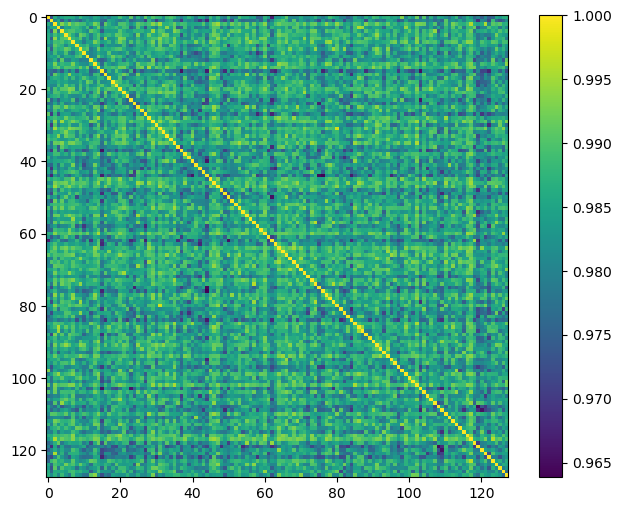

In [122]:
covmat = np.corrcoef(norm_signal)
plt.imshow(covmat[:128,:128])
plt.colorbar()

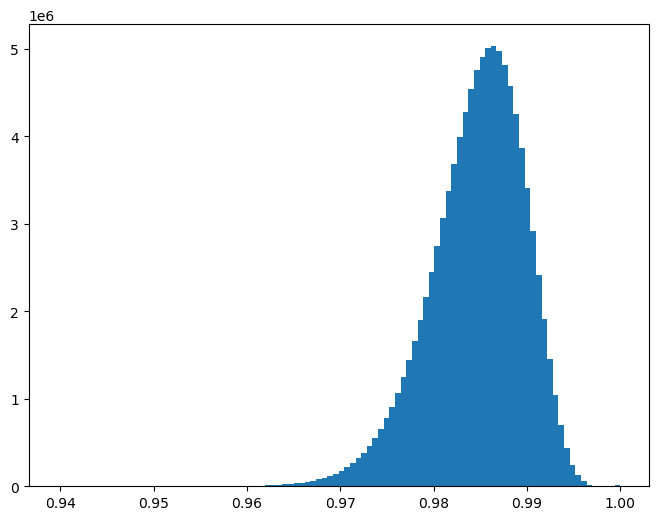

In [123]:
plt.hist(covmat.ravel(),bins=100);